In [1]:
import urllib.request
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# keras指定運行時顯卡及限制GPU用量
import os
import keras.backend.tensorflow_backend as KTF
from tensorflow.python.client import device_lib
import tensorflow as tf

import ML
ML.init()
Sess = ML.limitGPUByGrowth()
# 设置session
KTF.set_session(Sess)

E:\Program\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
E:\Program\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
E:\Program\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
E:\Program\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


/device:CPU:0
/device:GPU:0
Start using first GPU


In [2]:
url = 'http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls'
filepath = "E:/WorkSpace/TensorFlowWorkSpace/running_data/download_data/titanic3.xls"
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url,filepath)
    print(url)
    print('download:',result)

In [3]:
titani_df = pd.read_excel(filepath)
cols = ['survived','name','pclass','sex','age','sibsp','parch','fare','embarked'] #選取指定column
titani_df = titani_df[cols]
titani_df[:2]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,1,"Allen, Miss. Elisabeth Walton",1,female,29.0000,0,0,211.3375,S
1,1,"Allison, Master. Hudson Trevor",1,male,0.9167,1,2,151.5500,S


In [4]:
from sklearn import preprocessing #sklearn預處理模組
msk = np.random.rand(len(titani_df)) < 0.8
train_df = titani_df[msk]
test_df = titani_df[~msk]
print('train_df比例:',int(len(train_df)/len(titani_df)*100),',test_df比例:',int(len(test_df)/len(titani_df)*100))
print('total筆數',len(titani_df),',train筆數:',len(train_df),',test筆數:',len(test_df))

train_df比例: 79 ,test_df比例: 20
total筆數 1309 ,train筆數: 1042 ,test筆數: 267


In [5]:
def PreprocessData(raw_df):
    df = raw_df.drop(['name'],axis=1) #訓練df不需要name欄位
    age_mean = df['age'].mean() #age_mean :年齡平均值
    df['age'] = df['age'].fillna(age_mean) #將age欄中的空值填入平均值
    fare_mean = df['fare'].mean() #fare_mean :fare平均值
    df['fare'] = df['fare'].fillna(fare_mean)    
    df['sex'] = df['sex'].map({'female':0,'male':1}).astype(int) #將男女性別轉換為0和1
    
    x_OneHot_df = pd.get_dummies(data=df , columns=['embarked']) #將embarked欄位以pandas進行OneHot encode
    ndarray = x_OneHot_df.values
    
    Label = ndarray[:,0] #取出每筆資料的資料欄位0，作為Label
    Feature = ndarray[ : , 1:] #取出每筆資料的從欄位1之後的欄位，作為Feature
    
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1)) #建立標準化刻度
    if np.isnan(Feature).any(): # 檢查數據中是否有缺失值
        print('缺失值 : ',np.isnan(Feature).any()) 
        for dim1,i in enumerate(Feature):
            for dim2,j in enumerate(i):
                if np.isnan(j).any():
                    print(dim1,dim2,j)
                    i[dim2] = 0 #對缺失值進行填充處理
    scaleFeature = minmax_scale.fit_transform(Feature) #以minmax_scale標準化刻度進行標準化
    
    return scaleFeature,Label

train_Features,train_labels = PreprocessData(train_df)    
test_Features,test_labels = PreprocessData(test_df) 

In [6]:
train_Features[:2]

array([[0.        , 0.        , 0.36116884, 0.        , 0.        ,
        0.41250333, 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.00939458, 0.125     , 0.22222222,
        0.2958059 , 0.        , 0.        , 1.        ]])

In [7]:
test_Features[:2]

array([[0.        , 0.        , 0.23636329, 0.2       , 0.        ,
        0.86717485, 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.24999966, 0.2       , 0.        ,
        0.34713368, 1.        , 0.        , 0.        ]])

In [8]:
from keras.models import Sequential
from keras.layers import Dense,Dropout

model = Sequential()
model.add(Dense(input_dim = 9, #輸入層9神經元
                units=40, #隱藏層140神經元
                kernel_initializer='uniform',
                activation='relu'))

model.add(Dense(units=30, #隱藏層30神經元
                kernel_initializer='uniform',
                activation='relu'))

model.add(Dense(units=1, #輸出層1神經元
                kernel_initializer='uniform',
                activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                400       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 1,661
Trainable params: 1,661
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
train_history = model.fit(x=train_Features,
                          y=train_labels,
                         validation_split=0.1,
                         epochs=30,
                         batch_size=30,
                         verbose=2)

Train on 937 samples, validate on 105 samples
Epoch 1/30
 - 1s - loss: 0.6874 - acc: 0.6094 - val_loss: 0.6615 - val_acc: 0.7524
Epoch 2/30
 - 0s - loss: 0.6505 - acc: 0.6115 - val_loss: 0.5533 - val_acc: 0.7524
Epoch 3/30
 - 0s - loss: 0.5821 - acc: 0.6852 - val_loss: 0.4815 - val_acc: 0.7810
Epoch 4/30
 - 0s - loss: 0.5333 - acc: 0.7705 - val_loss: 0.4534 - val_acc: 0.7714
Epoch 5/30
 - 0s - loss: 0.5053 - acc: 0.7844 - val_loss: 0.4498 - val_acc: 0.8095
Epoch 6/30
 - 0s - loss: 0.4943 - acc: 0.7641 - val_loss: 0.4430 - val_acc: 0.8190
Epoch 7/30
 - 0s - loss: 0.4847 - acc: 0.7737 - val_loss: 0.4422 - val_acc: 0.8095
Epoch 8/30
 - 0s - loss: 0.4762 - acc: 0.7759 - val_loss: 0.4379 - val_acc: 0.8286
Epoch 9/30
 - 0s - loss: 0.4725 - acc: 0.7855 - val_loss: 0.4361 - val_acc: 0.8381
Epoch 10/30
 - 0s - loss: 0.4690 - acc: 0.7748 - val_loss: 0.4340 - val_acc: 0.8286
Epoch 11/30
 - 0s - loss: 0.4650 - acc: 0.7844 - val_loss: 0.4378 - val_acc: 0.8190
Epoch 12/30
 - 0s - loss: 0.4636 - acc:

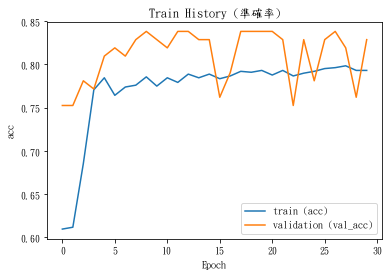

In [10]:
def show_train_history(train_history,train,validation,title):
    plt.plot(train_history.history[train]) #acc
    plt.plot(train_history.history[validation]) #val_acc
    plt.title('Train History ('+ title + ')')
    plt.xlabel('Epoch')
    plt.ylabel(train)
    plt.legend(['train (acc)','validation (val_acc)'],
    loc='lower right')
show_train_history(train_history,'acc','val_acc','準確率')

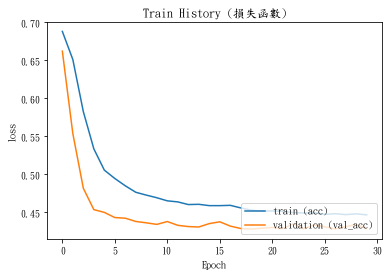

In [11]:
show_train_history(train_history,'loss','val_loss','損失函數')

In [12]:
scores = model.evaluate(x=test_Features,y=test_labels)
scores[1]

267/267 [==============================] - 0s 75us/step


0.8164794018652555

In [13]:
# 建立Jack & Rose的相關資料
Jack = pd.Series([0,'Jack',3,'male',23,1,0,5.0000,'S'])
Rose = pd.Series([1,'Rose',1,'female',20,1,0,100.0000,'S'])
JR_df = pd.DataFrame([list(Jack),list(Rose)],
                      columns=['survived','name','pclass','sex','age','sibsp','parch','fare','embarked'])

In [14]:
# 合併Jack & Rose的相關資料
all_df = pd.concat([titani_df,JR_df])
all_df[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,0,Jack,3,male,23.0,1,0,5.0,S
1,1,Rose,1,female,20.0,1,0,100.0,S


In [15]:
all_features,Label = PreprocessData(all_df)

In [16]:
all_probability = model.predict(all_features)
all_probability[:10]

array([[0.9728981 ],
       [0.51402754],
       [0.9671328 ],
       [0.33541617],
       [0.96505105],
       [0.25498658],
       [0.9337647 ],
       [0.2970061 ],
       [0.9219591 ],
       [0.278955  ]], dtype=float32)

In [17]:
all_df.insert(len(all_df.columns),'probability',all_probability) #插入新的columns
all_df[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,0,Jack,3,male,23.0,1,0,5.0,S,0.121322
1,1,Rose,1,female,20.0,1,0,100.0,S,0.963429


In [18]:
all_df[(all_df.survived==0)&(all_df.probability>0.9)] #生存機率大於1卻死亡的名單

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
2,0,"Allison, Miss. Helen Loraine",1,female,2.0,1,2,151.5500,S,0.967133
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0,1,2,151.5500,S,0.965051
105,0,"Evans, Miss. Edith Corse",1,female,36.0,0,0,31.6792,C,0.971848
169,0,"Isham, Miss. Ann Elizabeth",1,female,50.0,0,0,28.7125,C,0.970413
286,0,"Straus, Mrs. Isidor (Rosalie Ida Blun)",1,female,63.0,1,0,221.7792,S,0.950947


In [19]:
all_df[:5]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,1,"Allen, Miss. Elisabeth Walton",1,female,29.0000,0,0,211.3375,S,0.972898
1,1,"Allison, Master. Hudson Trevor",1,male,0.9167,1,2,151.5500,S,0.514028
2,0,"Allison, Miss. Helen Loraine",1,female,2.0000,1,2,151.5500,S,0.967133
3,0,"Allison, Mr. Hudson Joshua Creighton",1,male,30.0000,1,2,151.5500,S,0.335416
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0000,1,2,151.5500,S,0.965051
